<h2>GAN для генерации покемонов на основе датасета 
kaggle.com/hlrhegemony/pokemon-image-dataset

**<h4> Загрузка кода и весов с github**

In [ ]:
!git clone https://github.com/NotYourLady/PokemonGAN.git

!cp /content/PokemonGAN/PokUtils.py /content
!cp /content/PokemonGAN/PokNet.py /content
#!ls

fatal: destination path 'PokemonGAN' already exists and is not an empty directory.


In [ ]:
from PokUtils import (build_pokemon_dataset, show_batch, save_samples,
                      save_model, denorm)

from PokNet import Discriminator128, Generator128, get_noised_labels 

import torch
import torch.nn as nn
import random
import numpy as np

import shutil
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
import os


random.seed(69)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


**<h4> Загрузка датасета с Kaggle**

In [ ]:
import json
data = {"username":"trynottofly","key":"92f4117832fd8c85f41e37024984cd0f"}
with open('kaggle.json', 'w') as f:
    json.dump(data, f)

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download hlrhegemony/pokemon-image-dataset

! unzip "pokemon-image-dataset.zip"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
pokemon-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pokemon-image-dataset.zip
replace images/Abomasnow/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace images/Abomasnow/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Все покемоны цветные, хранятся в jpg, имеют белый фон, картинки некадратные. Всего покемонов - 899, всего изображений - 2503. 

**<h4> Обработка данных**


Я обрабатываю каждое изображение покемона следующим образом: сначала я делаю паддинг изображения до квадрартного белым фоном (фукция smart_resize()), тк у всех покемонов фон белый, я считаю, что очень важно оставить покемонов необрезанными по середине изображения. Далее я применяю повышение резкости с помощью функции adjust_sharpness() из pytorch, это позволяет выделить границы на изображениях и упростить работу с тенями и градиентами цвета. После множества экспериментов над датасетом, я решил, что буду генерировать ч/б покемонов, поэтому применяю функцию Grayscale из pytorch для перевода 3-х канальных изображений покемонов в одноканальные.

In [ ]:
pokemons = build_pokemon_dataset(data_dirs=["images"], img_size=128,
                                 aug_size=8, to_gray=True,
                                 edges=None, with_sharpness=5,
                                 memSTOP = 3)

0it [00:00, ?it/s]

**<h4> Аугментация**

Датасет у нас небольшой (для подобной задачи) - 2503 изображения, при этом в нем очень много покемонов разного вида (899видов), при этом у покемонов сильно отличаются как формы конечностей, так и их количество, отличаются размеры и даже рисовка,  поэтому необходима аугментация для расширения датасета. 

К каждому изображению я применяю афинное преобразование с поворотом на угол из (-60, 60) градусов, чтобы примерно сохранить ориентацию покемонов, а так же немного изменяю цвет функцией ColorJitter().

Полученные тензоры, имеющие значения в диапазоне (0, 1) я нормирую, приводя их значения к диапазону (-1, 1) 
Размер результирующего датасета (20024, 1, 128, 128) (в 8 раз больше изображений, чем в изначальном), но он занимает примерно 6GB, так что я решил для быстродействия его загрузить в оперативную память.

In [ ]:
print(pokemons.shape)
print(pokemons.min(), pokemons.max())

torch.Size([20024, 1, 128, 128])
tensor(-1.) tensor(0.9998)


*Предобработанные данные для обучения*

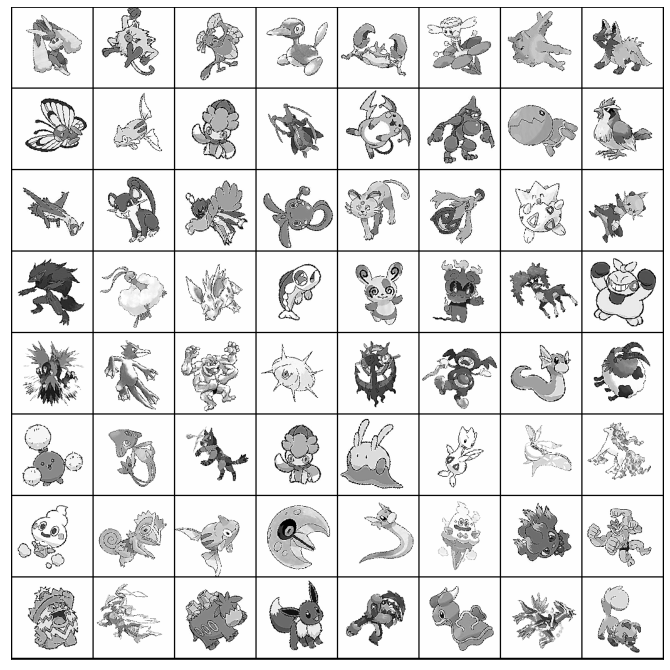

In [ ]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(pokemons, batch_size=batch_size, shuffle=True)
show_batch(train_loader)

**<h4> Архитектура сети**

Реализацию моей сети можно наблюдать в файле PokNet.py

Я использую GAN для генерации покемонов: для дискриминатора я использую 6 сверточных слоев размером (4, 4), с активационными функциями ReLU и батч нормализациями, что постепенно уменьшает размер входного изображения от 1х128х128 до 1x1 к которому применяется функция активации сигмоида, что можно интерпретировать как вероятность отнесенитя изображения к одному из двух классов GAN-a (в моем случае 1 - реальное изображение, 0 - сгенерированное) 

Для генератора я использую более сложную и тяжелую сеть: 
на вход приходит вектор шума из латентного пространства (после серии экспериментов я решил выбрать размерность латентного пространства - 256), далее
6 слоев обратных сверток превращают входной шум в изображение 1х128х128. 
В большинстве экспериментов, мой дискриминатор начинал слишком быстро побеждать генератор, поэтому я решил усложнить генератор добавлением ResNet блоков, которые будут вычленять допонительную информацию с помощью сверток, при этом не приводя к затуханию градиента.
На выходе к полученному тензору применяется гиперболический тангес одновременно как нелинейность и нормализация конечного изображения.

Я экспериментировал с loss-функциями BCE и MSE, во многих других случаях "из коробки" работает лучше MSE, однако для моей сети лучше подошла кросс-энтропия.

In [ ]:
latent_size = 256

In [ ]:
PokModel = {
    "discriminator": Discriminator128().to(device),
    "generator": Generator128(latent_size=latent_size, device=device, noiser_coef=0.5).to(device)
}

PokCriterion = {
    "discriminator": nn.BCELoss(), #nn.MSELoss(reduction='sum'), 
    "generator":  nn.BCELoss(), #nn.MSELoss(reduction='sum'), #nn.BCELoss()
}
index=0

print('Количество параметров discriminator',
      sum(np.product(t.shape) for t in PokModel["discriminator"].parameters()))
print('Количество параметров generator',
      sum(np.product(t.shape) for t in PokModel["generator"].parameters()))


Количество параметров discriminator 2795968
Количество параметров generator 15269696


**<h4> Фишки**

Для лучшего обучения я применил следующие трюки:
1. Т.к я отнормировал изображения при генерации, я и на выходе генератора буду ожидать изображения-тензоры такого отнормированного типа, поэтому я **убираю** и в генераторе и в дискрименаторе **bias'ы** на свертках, добавляю нормализацию на каждом этапе, а также функцию активации гиперболический тангенс в конце генератора. 
2. Я передаю в дискриминатор немного **зашумленные метки** (для реальных изображений значения чуть меньше единицы, и чуть больше нуля для сгенерированных картинок) - чтобы немного обманывать дискриминатор. (функция get_noised_labels()) 
3. На некотором этапе генерации я добавляю **шум к промежуточным значениям в генераторе**, что ограничить следующий эффект: генератор может запомнить один удачный паттерн покемона и генерировать только его, но я хочу разнообразия. (Для этого использую мой класс Noiser(nn.Module))

**<h4> Обучение сети**

Функция для обучения сети находится ниже. 
Функция оптимизации - Adam

Зашумление меток при обучении дискриминатора - нормальный шум N(0, 0.03)

Оценку качества работы сети на всех этапах я проводил своими глазами - написано несколько функций для визуализации и сохранения полученных изображений, тк как введенные лосс функции не дают достаточной информации для оценки качества работы сети (полезно только узнать, когда дискриминатор победил генератор и нужно останавливать обучение)

Обучения я проводил в 2 этапа:
1. Сначала я задал большой lr=0.01 для генератора и дискриминатора, добился получения нужных мне паттернов, а именно: глаза, тени, животные изгибы и тп. (тут конечной эпохой у меня стала 61-я, ее можно подгрузить в ноутбуке)
2. Далее я уменьшаю lr до 0.001 и ниже и запускаю обучение чтобы найти наиболее интересную мне вариацию найденного паттерна (ну и такого, чтобы результаты генерации можно было называть покемонами)

In [ ]:
def fit(model, criterion, epochs, fixed_latent,
        lrs=[0.001, 0.001], betas=[[0.5, 0.999],[0.5, 0.999]],
        latent_size=256,
        labels_noise_coef=0.002,
        sample_dir=None, models_path=None,
        name="GoodModel", start_index=0):

    assert sample_dir!=None
    assert models_path!=None
    
    path_to_save_model = models_path + f"/{name}_model_at_{int(time.time()//60)-27963162}"
    os.makedirs(path_to_save_model, exist_ok=True)

    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lrs[0], betas=(betas[0][0], betas[0][1])),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lrs[1], betas=(betas[1][0], betas[1][1]))
    }
    for epoch in range(start_index, epochs+start_index):
        model["discriminator"].train()
        model["generator"].train()
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_loader):
            real_images = real_images.to(device)
         ### Train discriminator
            optimizer["discriminator"].zero_grad()

         # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            #real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_targets = get_noised_labels([real_images.size(0), 1], 1, device, labels_noise_coef)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
         # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

         # Pass fake images through discriminator
            #fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_targets = get_noised_labels([fake_images.size(0), 1], 0, device, labels_noise_coef)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

         # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


         ### Train generator
         # Clear generator gradients
            optimizer["generator"].zero_grad()
            
         # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
         # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            #targets = get_noised_labels([batch_size, 1], 1)
            loss_g = criterion["generator"](preds, targets)
            
         # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        ### Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        ### Save generated images and weights
        if (epoch<40):
            if epoch%3==0:
                clear_output(True)
                save_samples(model["generator"], epoch, fixed_latent, sample_dir=sample_dir, show=True)
            if epoch%5==0:
                #clear_output(True)
                #save_samples(model["generator"], epoch, fixed_latent, sample_dir=sample_dir, show=True)
                save_model(model, path_to_save_model, epoch)    
        elif(epoch>=40 and epoch<60):
            if epoch%2==0:
                clear_output(True)
                save_samples(model["generator"], epoch, fixed_latent, sample_dir=sample_dir, show=True)
                save_model(model, path_to_save_model, epoch)    
        else:
            clear_output(True)
            save_samples(model["generator"], epoch, fixed_latent, sample_dir=sample_dir, show=True)  
            save_model(model, path_to_save_model, epoch)    


        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
PokModel["discriminator"].load_state_dict(torch.load("/content/PokemonGAN/epoch_61_2167-20230305T171523Z-001/epoch_61_2167/discriminator.zip"))
PokModel["generator"].load_state_dict(torch.load("/content/PokemonGAN/epoch_61_2167-20230305T171523Z-001/epoch_61_2167/generator.zip"))

<All keys matched successfully>

In [ ]:
epochs = 5
lrs = [0.0005, 0.001]
betas = [[0.6, 0.95],[0.6, 0.95]]
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
sample_dir = '/content/intermediate_results'
if os.path.exists(sample_dir):
  shutil.rmtree(sample_dir)
os.makedirs(sample_dir, exist_ok=True)

models_path = "/content/intermediate_models"
if os.path.exists(models_path):
  shutil.rmtree(models_path)
os.makedirs(models_path, exist_ok=True)

Saving generated-images-0060.png


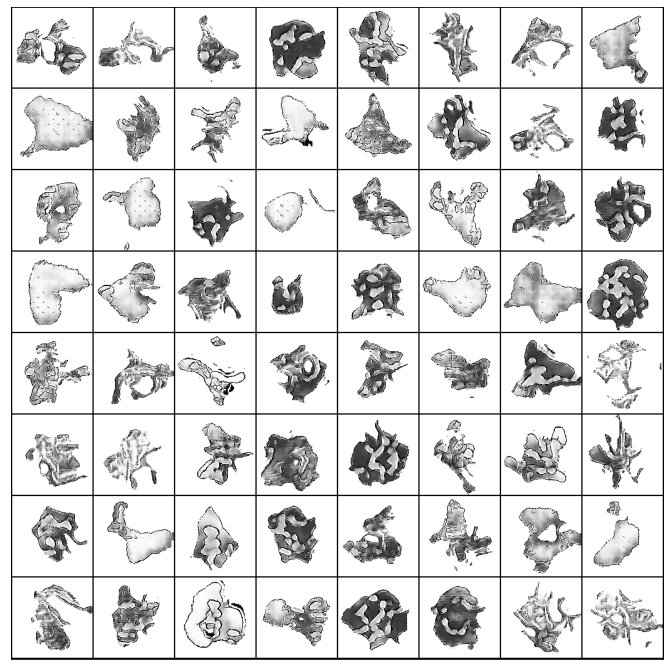

Epoch [61/5], loss_g: 3.2364, loss_d: 0.3705, real_score: 0.9023, fake_score: 0.0963


  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
history = fit(PokModel, PokCriterion, epochs, fixed_latent, lrs=lrs,
              betas=betas, labels_noise_coef=0.03,
              latent_size=latent_size, sample_dir=sample_dir,
              models_path=models_path, name="Model", start_index=60)



In [ ]:
del PokModel

**<h4> Обученная модель**

Здесь вы можете сгенерировать с помощью моей предобученной модели существ, которых я с гордостью называю покемонами 

In [ ]:
TESTgen = Generator128(latent_size=latent_size, device=device, noiser_coef=0.5).to(device)
TESTgen.load_state_dict(
    torch.load(
        "/content/PokemonGAN/epoch_75_2187-20230305T171654Z-001/epoch_75_2187/generator.zip"))

<All keys matched successfully>

Saving generated-images-0000.png


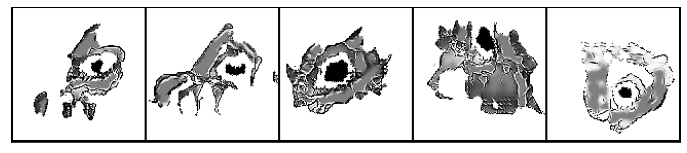

Saving generated-images-0001.png


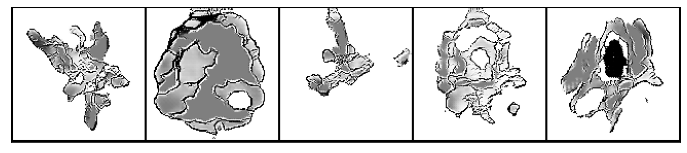

Saving generated-images-0002.png


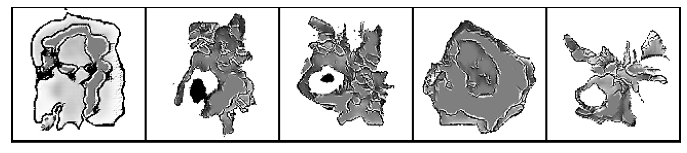

Saving generated-images-0003.png


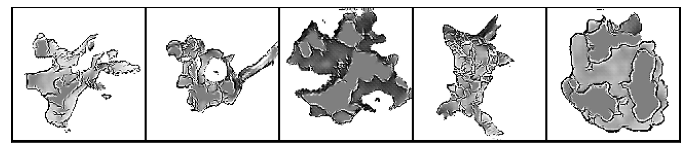

Saving generated-images-0004.png


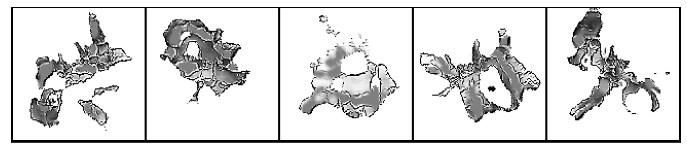

In [ ]:
TESTgen.eval()
dir = "/content/test"
os.makedirs(dir, exist_ok=True)   
for i in range(5):
    fixed_test = torch.randn(5, latent_size, 1, 1, device=device)
    save_samples(TESTgen, i, fixed_test, sample_dir=dir, show=True)

**<h4> Оценка качества генерации другим методом (может не хватить памяти GPU!)**

Я также хочу продемострировать следующюю метрику качетва генерации: **Leave-one-out 1-NN classifier accuracy**. Я сгенерирую 500 покемонов, возьму 500 покемонов из изначального датасета (на самом деле я возьму уже аугментированные изображения), получу для всех этих данных предстваление в некоторых векторах ResNet, обучу на этих данных 1-NN-классификатор, попрошу, чтобы он выдал классы другим реальным покемонан. В идеале, я хочу чтобы получилась точность 50%, но получилась **73%**, что свидетельвует о том, что модель работает неплохо не только по моей оценке, но и по оценке ResNet18, ведь именно эту предобученную модель я далее использую как сторонний классификатор.

*загрузка ResNet18*

In [ ]:
resnet_tester = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet_tester.eval()
print("g")

g


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


*трансформация моих данных под вход ResNet*

In [ ]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(224),
])

N = 500
data_real = denorm(pokemons[:N])

fixed_test = torch.randn(N, 256, 1, 1)
data_gen = denorm(TESTgen(fixed_test.to(device)))

data_real = preprocess(data_real)
data_gen = preprocess(data_gen)

real_batch = torch.stack([data_real[:, 0, :, :],
                           data_real[:, 0, :, :],
                           data_real[:, 0, :, :]], axis = 1)
gen_batch = torch.stack([data_gen[:, 0, :, :],
                         data_gen[:, 0, :, :],
                         data_gen[:, 0, :, :]], axis = 1)

print(real_batch.shape)
print(gen_batch.shape)

torch.Size([500, 3, 224, 224])
torch.Size([500, 3, 224, 224])


In [ ]:
if torch.cuda.is_available():
    real_batch = real_batch.to('cuda')
    gen_batch = gen_batch.to('cuda')
    resnet_tester.to('cuda')

with torch.no_grad():
    output_real = resnet_tester(real_batch)
    output_gen = resnet_tester(gen_batch)
    
print(output_real.shape)
print(output_gen.shape)


torch.Size([500, 1000])
torch.Size([500, 1000])


In [ ]:
import pandas as pd
df_real = pd.DataFrame(output_real)
lb_real = pd.DataFrame(np.ones(len(df_real)).astype(int))

df_gen = pd.DataFrame(output_gen)
lb_gen = pd.DataFrame(np.zeros(len(df_gen)).astype(int))

In [ ]:
X = df_gen.append(df_real)
y = lb_gen.append(lb_real)
print(X.shape)
print(y.shape)

(1000, 1000)
(1000, 1)


*Обучение 1-NN-классификатора*

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf =  KNeighborsClassifier(n_neighbors=1,
                            algorithm='auto',
                            metric='euclidean',
                            n_jobs=-1)

clf.fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=1)

*Расчет метрики на 300 реальных покемонах*

In [ ]:
data_real_val = denorm(pokemons[N:N+300])

data_real_val = preprocess(data_real_val)

real_batch_val = torch.stack([data_real_val[:, 0, :, :],
                              data_real_val[:, 0, :, :],
                              data_real_val[:, 0, :, :]], axis = 1)


if torch.cuda.is_available():
    real_batch_val = real_batch_val.to('cuda')

In [ ]:
with torch.no_grad():
    output_real_val = resnet_tester(real_batch_val)

df_real_val = pd.DataFrame(output_real_val)

In [ ]:
print(clf.predict(df_real_val).mean())

0.7333333333333333


Таким образом, классификатор в **27%** случаев считал, что покемон сгенерированный, а не реальный